In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip
./__notebook__.ipynb


In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report,accuracy_score

In [3]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

## Loading datasets

In [4]:
train_data = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip', sep='\t')
test_data = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip', sep='\t')

train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
print(train_data.shape,test_data.shape)


(156060, 4) (66292, 3)


In [6]:
print(train_data.iloc[1]["Phrase"])

A series of escapades demonstrating the adage that what is good for the goose


In [7]:
y_pred = [2] * len(train_data.Sentiment)
print('The baseline accuracy: %.3f' 
      %accuracy_score(y_pred, train_data.Sentiment))

The baseline accuracy: 0.510


In [8]:
test_data.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


## Preprocessing Phrase

TODO:
- Tokenize
- Lemmatize
- Remove non alphabet character

In [9]:
import spacy #lemmas and remove non-character
nlp = spacy.load('en_core_web_sm')

def preprocess_phrase(document):
    preprocessed_texts = []
    
    for text in document['Phrase'].values:
        text = str(text)
        result = [token.lemma_ for token in nlp(text) if token.is_alpha]
        preprocessed_texts.append(" ".join(result))
        
    return preprocessed_texts

In [10]:
train_sent = preprocess_phrase(train_data)
#test_sent = preprocess_phrase(test_data)

#print(len(train_sent), len(test_sent))

print(len(train_sent))

156060


## Generate train and validation test

In [11]:
target =train_data['Sentiment'].values

X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    train_sent,
    target,
    train_size=0.9,
    stratify=target,
    shuffle = True,
    random_state = 42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_valid,
    y_train_valid,
    train_size=0.85,
    stratify=y_train_valid,
    shuffle = True,
    random_state = 42
)
print(len(X_train), len(X_val),len(X_test), len(y_train), len(y_val),len(y_test))

119385 21069 15606 119385 21069 15606


## Model Creation

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from transformers import TFAutoModel

In [13]:
unique_words = set()
len_max = 0

for sent in X_train:
    tokens = sent.split()
    unique_words.update(tokens)
    
    if len_max < len(tokens):
        len_max = len(tokens)

print(len(unique_words), len_max)

14243 47


In [14]:
# Build model input
len_max=60
input_ids = Input(shape=(len_max,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(len_max,), name='attention_mask', dtype='int32') 
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

bert = TFAutoModel.from_pretrained('bert-base-uncased')
embeddings = bert.bert(inputs)[1]

# convert bert embeddings into 5 output classes
output = Flatten()(embeddings)
output = Dense(256, activation='relu')(output)
#output= tf.keras.layers.Dropout(0.2)(output)
output = Dense(128, activation='relu')(output)
#output= tf.keras.layers.Dropout(0.2)(output)
output = Dense(5, activation='softmax', name='outputs')(output)

model = Model(inputs=inputs, outputs=output)

# Take a look at the model
model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
flatten (Flatten)               (None, 768)          0           bert[0][1]                   

In [15]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05),
    metrics=['accuracy']
)

In [16]:
# Encode the texts

def encode_texts(text_list, tokenizer, max_length=len_max):
    return tokenizer(text_list, 
                     add_special_tokens=True,  
                     max_length=len_max,    
                     truncation=True,         
                     padding='max_length',    
                     return_tensors='tf') 

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = encode_texts(X_train, tokenizer)
val_encodings = encode_texts(X_val, tokenizer)
test_encodings = encode_texts(X_test, tokenizer)

train_target=tf.keras.utils.to_categorical(y_train, num_classes=5)
valid_target=tf.keras.utils.to_categorical(y_val, num_classes=5)

train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']}, train_target)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']}, valid_target)).batch(32)
#test_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']}, test_labels))


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [17]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)


Epoch 1/3
3731/3731 [==============================] - 957s 252ms/step - loss: 0.8395 - accuracy: 0.6517 - val_loss: 0.7366 - val_accuracy: 0.6950
Epoch 2/3
3731/3731 [==============================] - 939s 252ms/step - loss: 0.6989 - accuracy: 0.7087 - val_loss: 0.7213 - val_accuracy: 0.7000
Epoch 3/3
3731/3731 [==============================] - 940s 252ms/step - loss: 0.6304 - accuracy: 0.7383 - val_loss: 0.7397 - val_accuracy: 0.6983


In [18]:
model.save('./Bert.h5')

In [19]:
model.save_weights('Bert_weights.h5')

## Fit Model

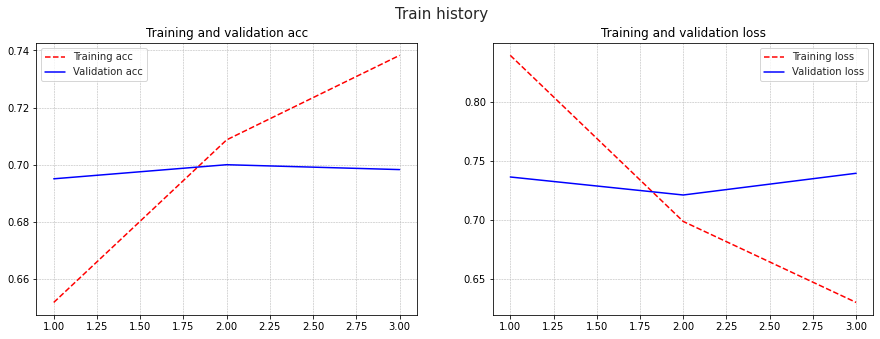

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "r--", label = "Training acc")
ax1.plot(epochs, val_acc, "b-", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()
ax1.grid(True, linestyle='--', linewidth=0.5)

ax2.plot(epochs, loss, "r--", label = "Training loss")
ax2.plot(epochs, val_loss, "b-", label = "Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.show()

In [21]:
test_dataset = tf.data.Dataset.from_tensor_slices({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']}).batch(32)


y_pred1 = model.predict(test_dataset)

y_pred = np.argmax(y_pred1,axis=1)


accuracy = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

recall = recall_score(y_test, y_pred, average='weighted')

precision = precision_score(y_test, y_pred,average="weighted")

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:",precision)
print("F1 Score:", f1)
print(classification_report(y_test,  y_pred))

Accuracy: 0.6952454184288094
Recall: 0.6952454184288094
Precision: 0.6956536406677652
F1 Score: 0.6946314684979579
              precision    recall  f1-score   support

           0       0.52      0.47      0.49       707
           1       0.57      0.64      0.60      2727
           2       0.79      0.79      0.79      7958
           3       0.63      0.61      0.62      3293
           4       0.65      0.52      0.58       921

    accuracy                           0.70     15606
   macro avg       0.63      0.61      0.62     15606
weighted avg       0.70      0.70      0.69     15606



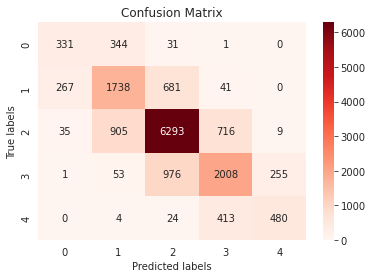

In [22]:
confu_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confu_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=range(0,5), yticklabels=range(0,5))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()